# Train faster, more flexible models with Amazon SageMaker Linear Learner

Today Amazon SageMaker is launching several additional features to the built-in linear learner algorithm.  Amazon SageMaker algorithms are designed to scale effortlessly to massive datasets and take advantage of the latest hardware optimizations for unparalleled speed.  The Amazon SageMaker linear learner algorithm encompasses both linear regression and binary classification algorithms.  These algorithms are used extensively in banking, fraud/risk management, insurance, and healthcare.  The new features of linear learner are designed to speed up training and help you customize models for different use cases.  Examples include classification with unbalanced classes, where one of your outcomes happens far less frequently than another.  Or specialized loss functions for regression, where it’s more important to penalize certain model errors more than others.

In this blog post we'll cover three things:
1. Early stopping and saving the best model
1. New ways to customize linear learner models, including:
   * Hinge loss (support vector machines)
   * Quantile loss
   * Huber loss
   * Epsilon-insensitive loss
   * Class weights options
1. Then we'll walk you through a hands-on example of using class weights to boost performance in binary classification

## Early Stopping

Linear learner trains models using Stochastic Gradient Descent (SGD) or variants of SGD like Adam.  Training requires multiple passes over the data, called *epochs*, in which the data are loaded into memory in chunks called *batches*, sometimes called *minibatches*.  How do we know how many epochs to run?  Ideally, we'd like to continue training until convergence - that is, until we no longer see any additional benefits.  Running additional epochs after the model has converged is a waste of time and money, but guessing the right number of epochs is difficult to do before submitting a training job.  If we train for too few epochs, our model will be less accurate than it should be, but if we train for too many epochs, we'll waste resources and potentially harm model accuracy by overfitting.  To remove the guesswork and optimize model training, linear learner has added two new features: automatic early stopping and saving the best model.  

Early stopping works in two basic regimes: with or without a validation set.  Often we split our data into training, validation, and testing data sets.  Training is for optimizing the loss, validation is for tuning hyperparameters, and testing is for producing an honest estimate of how the model will perform on unseen data in the future.  If you provide linear learner with a validation data set, training will stop early when validation loss stops improving.  If no validation set is available, training will stop early when training loss stops improving.

#### Early Stopping with a validation data set
One big benefit of having a validation data set is that we can tell if and when we start overfitting to the training data.  Overfitting is when the model gives predictions that are too closely tailored to the training data, so that generalization performance (performance on future unseen data) will be poor.  The following plot on the right shows a typical progression during training with a validation data set.  Until epoch 5, the model has been learning from the training set and doing better and better on the validation set.  But in epochs 7-10, we see that the model has begun to overfit on the training set, which shows up as worse performance on the validation set.  Regardless of whether the model continues to improve (overfit) on the training data, we want to stop training after the model starts to overfit.  And we want to restore the best model from just before the overfitting started.  These two features are now turned on by default in linear learner.  

The default parameter values for early stopping are shown in the following code.  To tweak the behavior of early stopping, try changing the values.  To turn off early stopping entirely, choose a patience value larger than the number of epochs you want to run.

    early_stopping_patience=3,
    early_stopping_tolerance=0.001,

The parameter early_stoping_patience defines how many epochs to wait before ending training if no improvement is made.  It's useful to have a little patience when deciding to stop early, since the training curve can be bumpy.  Performance may get worse for one or two epochs before continuing to improve.  By default, linear learner will stop early if performance has degraded for three epochs in a row.

The parameter early_stopping_tolerance defines the size of an improvement that's considered significant.  If the ratio of the improvement in loss divided by the previous best loss is smaller than this value, early stopping will consider the improvement to be zero.

#### Early stopping without a validation data set

When training with a training set only, we have no way to detect overfitting.  But we still want to stop training once the model has converged and improvement has levelled off.  In the left panel of the following figure, that happens around epoch 25.

<img src="images/early_stop.png">

#### Early stopping and calibration
You may already be familiar with the linear learner automated threshold tuning for binary classification models.  Threshold tuning and early stopping work together seamlessly by default in linear learner.  

When a binary classification model outputs a probability (e.g., logistic regression) or a raw score (SVM), we convert that to a binary prediction by applying a threshold, for example:

    predicted_label = 1 if raw_prediction > 0.5 else 0

We might want to tune the threshold (0.5 in the example) based on the metric we care about most, such as accuracy or recall.  Linear learner does this tuning automatically using the 'binary_classifier_model_selection_criteria' parameter.  When threshold tuning and early stopping are both turned on (the default), then training stops early based on the metric you request.  For example, if you provide a validation data set and request a logistic regression model with threshold tuning based on accuracy, then training will stop when the model with auto-thresholding reaches optimal performance on the validation data.  If there is no validation set and auto-thresholding is turned off, then training will stop when the best value of the loss function on the training data is reached.

## New loss functions

The loss function is our definition of the cost of making an error in prediction.  When we train a model, we push the model weights in the direction that minimizes loss, given the known labels in the training set.  The most common and well-known loss function is squared loss, which is minimized when we train a standard linear regression model.  Another common loss function is the one used in logistic regression, variously known as logistic loss, cross-entropy loss, or binomial likelihood.  Ideally, the loss function we train on should be a close match to the business problem we're trying to solve.  Having the flexibility to choose different loss functions at training time allows us to customize models to different use cases.  In this section, we'll discuss when to use which loss function, and introduce several new loss functions that have been added to linear learner.

<img src="images/loss_functions.png">

### Squared loss

    predictor_type='regressor',
    loss='squared_loss',

$$\text{argmin}_{w_0, \mathbf{w}} \sum_{i=1}^{N} (w_0 + \mathbf{x_i}^\intercal \mathbf{w} - y_i)^2$$

We'll use the following notation in all of the loss functions we discuss:

$w_0$ is the bias that the model learns

$\mathbf{w}$ is the vector of feature weights that the model learns

$y_i$ and $\mathbf{x_i}$ are the label and feature vector, respectively, from example $i$ of the training data

$N$ is the total number of training examples

Squared loss is a first choice for most regression problems.  It has the nice property of producing an estimate of the mean of the label given the features.  As seen in the plot above, squared loss implies that we pay a very high cost for very wrong predictions.  This can cause problems if our training data include some extreme outliers.  A model trained on squared loss will be very sensitive to outliers.  Squared loss is sometimes known as mean squared error (MSE), ordinary least squares (OLS), or $\text{L}_2$ loss.   Read more about [squared loss](https://en.wikipedia.org/wiki/Least_squares) on wikipedia.

### Absolute loss

    predictor_type='regressor',
    loss='absolute_loss',

$$\text{argmin}_{w_0, \mathbf{w}} \sum_{i=1}^{N} |w_0 + \mathbf{x_i}^\intercal \mathbf{w} - y_i|$$

Absolute loss is less common than squared loss, but can be very useful.  The main difference between the two is that training a model on absolute loss will produces estimates of the median of the label given the features.  Squared loss estimates the mean, and absolute loss estimates the median.  Whether you want to estimate the mean or median will depend on your use case.  Let's look at a few examples:
* If an error of -2 costs you \$2 and an error of +50 costs you \$50, then absolute loss models your costs better than squared loss.  
* If an error of -2 costs you \$2, while an error of +50 is simply unacceptably large, then it's important that your errors are generally small, and so squared loss is probably the right fit.  
* If it's important that your predictions are too high as often as they're too low, then you want to estimate the median with absolute loss.  
* If outliers in your training data are having too much influence on the model, try switching from squared to absolute loss.  Large errors get a large amount of attention from absolute loss, but with squared loss, large errors get squared and become huge errors attracting a huge amount of attention.  If the error is due to an outlier, it might not deserve a huge amount of attention.

Absolute loss is sometimes also known as $\text{L}_1$ loss or least absolute error.  Read more about [absolute loss](https://en.wikipedia.org/wiki/Least_absolute_deviations) on wikipedia.

### Quantile loss

    predictor_type='regressor',
    loss='quantile_loss',
    quantile=0.9,

$$ \text{argmin}_{w_0, \mathbf{w}} \sum_{i=1}^N q(y_i - w_o - \mathbf{x_i}^\intercal \mathbf{w})^\text{+} + (1-q)(w_0 + \mathbf{x_i}^\intercal \mathbf{w} - y_i)^\text{+} $$

$$ \text{where the parameter } q \text{ is the quantile you want to predict}$$

Quantile loss lets us predict an upper or lower bound for the label, given the features. To make predictions that are larger than the true label 90% of the time, train quantile loss with the 0.9 quantile. An example would be predicting electricity demand where we want to build near peak demand since building to the average would result in brown-outs and upset customers.  Read more about [quantile loss](https://en.wikipedia.org/wiki/Quantile_regression) on wikipedia.

### Huber loss

    predictor_type='regressor',
    loss='huber_loss',
    huber_delta=0.5,

$$ \text{Let the error be } e_i = w_0 + \mathbf{x_i}^\intercal \mathbf{w} - y_i \text{.  Then Huber loss solves:}$$

$$ \text{argmin}_{w_0, \mathbf{w}} \sum_{i=1}^N I(|e_i| < \delta) \frac{e_i^2}{2} + I(|e_i| >= \delta) |e_i|\delta - \frac{\delta^2}{2} $$

$$ \text{where } I(a) = 1 \text{ if } a \text{ is true, else } 0 $$

Huber loss is an interesting hybrid of $\text{L}_1$ and $\text{L}_2$ losses.  Huber loss counts small errors on a squared scale and large errors on an absolute scale.  In the plot above, we see that Huber loss looks like squared loss when the error is near 0 and absolute loss beyond that.  Huber loss is useful when we want to train with squared loss, but want to avoid squared loss's sensitivity to outliers.  Huber loss gives less importance to outliers by not squaring the larger errors.  Read more about [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) on wikipedia.

### Epsilon-insensitive loss


    predictor_type='regressor',
    loss='eps_insensitive_squared_loss',
    loss_insensitivity=0.25,


For epsilon-insensitive squared loss, we minimize
$$ \text{argmin}_{w_0, \mathbf{w}} \sum_{i=1}^N max(0, (w_0 + \mathbf{x_i}^\intercal \mathbf{w} - y_i)^2 - \epsilon^2) $$

And for epsilon-insensitive absolute loss, we minimize

$$ \text{argmin}_{w_0, \mathbf{w}} \sum_{i=1}^N max(0, |w_0 + \mathbf{x_i}^\intercal \mathbf{w} - y_i| - \epsilon) $$

Epsilon-insensitive loss is useful when errors don't matter to you as long as they're below some threshold.  Set the threshold that makes sense for your use case as epsilon.  Epsilon-insensitive loss will allow the model to pay no cost for making errors smaller than epsilon.

### Logistic regression

    predictor_type='binary_classifier',
    loss='logistic',
    binary_classifier_model_selection_criteria='recall_at_target_precision',
    target_precision=0.9,

Each of the losses we've discussed is for regression problems, where the labels are floating point numbers.  The last two losses we'll cover, logistic regression and support vector machines, are for binary classification problems where the labels are one of two classes.  Linear learner expects the class labels to be 0 or 1.  This may require some preprocessing, for example if your labels are coded as -1 and +1, or as blue and yellow.  Logistic regression produces a predicted probability for each data point:

$$ p_i = \sigma(w_0 + \mathbf{x_i}^\intercal \mathbf{w}) $$

The loss function minimized in training a logistic regression model is the log likelihood of a binomial distribution.  It assigns the highest cost to predictions that are confident and wrong, for example a prediction of 0.99 when the true label was 0, or a prediction of 0.002 when the true label was positive.  The loss function is:

$$ \text{argmin}_{w_0, \mathbf{w}} \sum_{i=1}^N y_i  \text{log}(p) - (1 - y_i) \text{log}(1 - p) $$  

$$ \text{where } \sigma(x) = \frac{\text{exp}(x)}{1 + \text{exp}(x)}  $$

Read more about [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) on wikipedia.

### Hinge loss (support vector machine)

    predictor_type='binary_classifier',
    loss='hinge_loss',
    margin=1.0,
    binary_classifier_model_selection_criteria='recall_at_target_precision',
    target_precision=0.9,

Another popular option for binary classification problems is the hinge loss, also known as a Support Vector Machine (SVM) or Support Vector Classifier (SVC) with a linear kernel.  It places a high cost on any points that are misclassified or nearly misclassified.  To tune the meaning of "nearly", adjust the margin parameter:

It's difficult to say in advance whether logistic regression or SVM will be the right model for a binary classification problem, though logistic regression is generally a more popular choice then SVM.  If it's important to provide probabilities of the predicted class labels, then logistic regression will be the right choice.  If all that matters is better accuracy, precision, or recall, then either model may be appropriate.  One advantage of logistic regression is that it produces the probability of an example having a positive label.  That can be useful, for example in an ad serving system where the predicted click probability is used as an input to a bidding mechanism.  Hinge loss does not produce class probabilities.

Whichever model you choose, you're likely to benefit from linear learner's options for tuning the threshold that separates positive from negative predictions

$$\text{argmin}_{w_0, \mathbf{w}} \sum_{i=1}^{N} y_i(\frac{m+1}{2} - w_0 - \mathbf{x_i}^\text{T}\mathbf{w})^\text{+} + (1-y_i)\frac{m-1}{2} + w_o + \mathbf{x_i}^\text{T}\mathbf{w})^\text{+}$$

$$\text{where  } a^\text{+} = \text{max}(0, a)$$


Note that the hinge loss we use is a reparameterization of the usual hinge loss: typically hinge loss expects the binary label to be in {-1, 1}, whereas ours expects the binary labels to be in {0, 1}.  This reparameterization allows LinearLearner to accept the same data format for binary classification regardless of the training loss.  Read more about [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss) on wikipedia.

## Class weights
In some binary classification problems, we may find that our training data is highly unbalanced.  For example, in credit card fraud detection, we're likely to have many more examples of non-fraudulent transactions than fraudulent.  In these cases, balancing the class weights may improve model performance.
 
Suppose we have 98% negative and 2% positive examples.  To balance the total weight of each class, we can set the positive class weight to be 49.  Now the average weight from the positive class is 0.98 $\cdot$ 1 = 0.98, and the average weight from the negative class is 0.02 $\cdot$ 49 = 0.98.  The negative class weight multiplier is always 1.
 
To incorporate the positive class weight in training, we multiply the loss by the positive weight whenever we see a positive class label.  For logistic regression, the weighted loss is:

Weighted logistic regression:

$$ \text{argmin}_{w_0, \mathbf{w}} \sum_{i=1}^N p y_i  \text{log}(\sigma(w_0 + \mathbf{x_i}^\intercal \mathbf{w})) - (1 - y_i) \text{log}(1 - \sigma(w_0 + \mathbf{x_i}^\intercal \mathbf{w})) $$  

$$ \text{where } p \text{ is the weight for the positive class.} $$
 
The only difference between the weighted and unweighted logistic regression loss functions is the presense of the class weight, $p$ on the left-hand term in the loss.  Class weights in the hinge loss (SVM) classifier are applied in the same way.

To apply class weights when training a model with linear learner, supply the weight for the positive class as a training parameter:

    positive_example_weight_mult=200,

Or to ask linear learner to calculate the positive class weight for you:

    positive_example_weight_mult='balanced',

## Hands-on example: Detecting credit card fraud

In this section, we'll look at a credit card fraud detection dataset.  The data set (Dal Pozzolo et al. 2015) was downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data).  We have features and labels for over a quarter million credit card transactions, each of which is labeled as fraudulent or not fraudulent.  We'd like to train a model based on the features of these transactions so that we can predict risky or fraudulent transactions in the future.  This is a binary classification problem.  

We'll walk through training linear learner with various settings and deploying an inference endpoint.  We'll evaluate the quality of our models by hitting that endpoint with observations from the test set.  We can take the real-time predictions returned by the endpoint and evaluate them against the ground-truth labels in our test set.

Next, we'll apply the linear learner threshold tuning functionality to get better precision without sacrificing recall.  Then, we'll push the precision even higher using the linear learner new class weights feature.  Because fraud can be extremely costly, we would prefer to have high recall, even if this means more false positives.  This is especially true if we are building a first line of defense, flagging potentially fraudulent transactions for further review before taking actions that affect customers.

First we'll do some preprocessing on this data set: we'll shuffle the examples and split them into train and test sets.  To run this under notebook under your own AWS account, you'll need to change the Amazon S3 locations.  First download the raw data from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data) and upload to your SageMaker notebook instance (or wherever you're running this notebook).  Only 0.17% of the data have positive labels, making this a challenging classification problem.

In [1]:
import boto3
import io
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd 

import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer

In [2]:
# Set data locations
bucket = 'beyoung-app'                        # replace this with your own bucket
prefix = 'sagemaker/fraud-linear-learner-loss-weights'   # replace this with your own prefix
s3_train_key = '{}/train/recordio-pb-data'.format(prefix)
s3_train_path = os.path.join('s3://', bucket, s3_train_key)
local_raw_data = 'creditcardfraud.zip'
role = get_execution_role()

In [3]:
# Confirm access to s3 bucket
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    print(obj.key)

awscli-bundle/install
awscli-bundle/packages/PyYAML-3.13.tar.gz
awscli-bundle/packages/argparse-1.2.1.tar.gz
awscli-bundle/packages/awscli-1.16.174.tar.gz
awscli-bundle/packages/botocore-1.12.164.tar.gz
awscli-bundle/packages/colorama-0.3.9.tar.gz
awscli-bundle/packages/docutils-0.14.tar.gz
awscli-bundle/packages/futures-3.2.0.tar.gz
awscli-bundle/packages/jmespath-0.9.4.tar.gz
awscli-bundle/packages/ordereddict-1.1.tar.gz
awscli-bundle/packages/pyasn1-0.4.5.tar.gz
awscli-bundle/packages/python-dateutil-2.6.1.tar.gz
awscli-bundle/packages/python-dateutil-2.8.0.tar.gz
awscli-bundle/packages/rsa-3.4.2.tar.gz
awscli-bundle/packages/s3transfer-0.2.1.tar.gz
awscli-bundle/packages/setup/setuptools_scm-1.15.7.tar.gz
awscli-bundle/packages/simplejson-3.3.0.tar.gz
awscli-bundle/packages/six-1.12.0.tar.gz
awscli-bundle/packages/urllib3-1.22.tar.gz
awscli-bundle/packages/urllib3-1.25.3.tar.gz
awscli-bundle/packages/virtualenv-15.1.0.tar.gz
deeplen-sm/test/hotdog_or_not_model-0000.params
deeplen-s

In [5]:
df_fraud = pd.read_csv(local_raw_data)
total_row, total_feature = df_fraud.shape

In [6]:
# percentage of data
cls_fraud_1 = df_fraud['Class'].value_counts()[1]
cls_normal_0 = df_fraud['Class'].value_counts()[0]


print('# of fraud: ' + str(cls_fraud_1) + ' % of fraud: ' + str(cls_fraud_1 / total_row * 100))
print('# of normal: ' + str(cls_normal_0) + ' % of normal: ' + str(cls_normal_0 / total_row * 100))


# of fraud: 492 % of fraud: 0.1727485630620034
# of normal: 284315 % of normal: 99.82725143693798


In [7]:
df_fraud.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

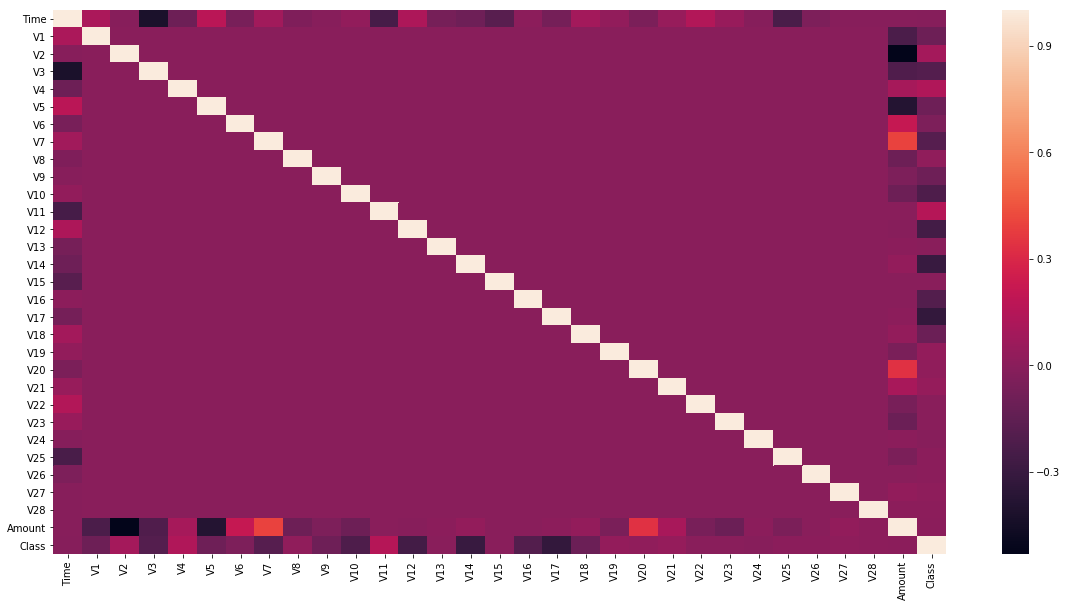

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,10))

corr = df_fraud.corr()
sns.heatmap(corr)

plt.show()

In [9]:
corr['Class'].sort_values()

V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V6       -0.043643
Time     -0.012323
V24      -0.007221
V13      -0.004570
V15      -0.004223
V23      -0.002685
V22       0.000805
V25       0.003308
V26       0.004455
Amount    0.005632
V28       0.009536
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V2        0.091289
V4        0.133447
V11       0.154876
Class     1.000000
Name: Class, dtype: float64

In [10]:
# Read the data, shuffle, and split into train and test sets, separating the labels (last column) from the features
raw_data = pd.read_csv(local_raw_data).as_matrix()
np.random.seed(0)
np.random.shuffle(raw_data)
train_size = int(raw_data.shape[0] * 0.7)
train_features  = raw_data[:train_size, :-1]
train_labels = raw_data[:train_size, -1]
test_features = raw_data[train_size:, :-1]
test_labels = raw_data[train_size:, -1]

# Convert the processed training data to protobuf and write to S3 for linear learner
vectors = np.array([t.tolist() for t in train_features]).astype('float32')
labels = np.array([t.tolist() for t in train_labels]).astype('float32')
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(s3_train_key).upload_fileobj(buf)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


We'll wrap the model training setup in a convenience function that takes in the S3 location of the training data, the model hyperparameters that define our training job, and the S3 output path for model artifacts.  Inside the function, we'll hardcode the algorithm container, the number and type of EC2 instances to train on, and the input and output data formats.

In [11]:
from sagemaker.amazon.amazon_estimator import get_image_uri

def predictor_from_hyperparams(s3_train_data, hyperparams, output_path):
    """
    Create an Estimator from the given hyperparams, fit to training data, and return a deployed predictor
    """
    # specify algorithm containers and instantiate an Estimator with given hyperparams
    container = get_image_uri(boto3.Session().region_name, 'linear-learner')

    linear = sagemaker.estimator.Estimator(container,
        role,
        train_instance_count=1,
        train_instance_type='ml.m4.xlarge',
        output_path=output_path,
        sagemaker_session=sagemaker.Session())
    linear.set_hyperparameters(**hyperparams)
    # train model
    linear.fit({'train': s3_train_data})
    # deploy a predictor
    linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
    linear_predictor.content_type = 'text/csv'
    linear_predictor.serializer = csv_serializer
    linear_predictor.deserializer = json_deserializer
    return linear_predictor

And add another convenience function for setting up a hosting endpoint, making predictions, and evaluating the model.  To make predictions, we need to set up a model hosting endpoint.  Then we feed test features to the endpoint and receive predicted test labels.  To evaluate the models we create in this exercise, we'll capture predicted test labels and compare them to actuals using some common binary classification metrics.

In [12]:
def evaluate(linear_predictor, test_features, test_labels, model_name, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  Return binary classification metrics.
    """
    # split the test data set into 100 batches and evaluate using prediction endpoint
    prediction_batches = [linear_predictor.predict(batch)['predictions'] for batch in np.array_split(test_features, 100)]
    # parse raw predictions json to exctract predicted label
    test_preds = np.concatenate([np.array([x['predicted_label'] for x in batch]) for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1 = 2 * precision * recall / (precision + recall)
    
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print("{:<11} {:.3f}".format('F1:', f1))
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy, 
             'F1': f1, 'Model': model_name}

And finally we'll add a convenience function to delete prediction endpoints after we're done with them:

In [13]:
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

Let's begin by training a binary classifier model with the linear learner default settings.  Note that we're setting the number of epochs to 40, which is much higher than the default of 10 epochs.  With early stopping, we don't have to worry about setting the number of epochs too high.  Linear learner will stop training automatically after the model has converged.

In [ ]:
# Training a binary classifier with default settings: logistic regression
defaults_hyperparams = {
    'feature_dim': 30,
    'predictor_type': 'binary_classifier',
    'epochs': 40
}
defaults_output_path = 's3://{}/{}/defaults/output'.format(bucket, prefix)
defaults_predictor = predictor_from_hyperparams(s3_train_path, defaults_hyperparams, defaults_output_path)

2019-09-11 21:53:16 Starting - Starting the training job...
2019-09-11 21:53:35 Starting - Launching requested ML instances......
2019-09-11 21:54:38 Starting - Preparing the instances for training......
2019-09-11 21:55:38 Downloading - Downloading input data...
2019-09-11 21:56:01 Training - Downloading the training image..[2019-09-11 21:57:03.536] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 6782, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00624776498756217, "sum": 0.00624776498756217, "min": 0.00624776498756217}}, "EndTime": 1568239023.536408, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1568239023.536293}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005181972491681276, "sum": 0.005181972491681

[2019-09-11 21:57:16.104] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 17, "duration": 6257, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005566463126609074, "sum": 0.005566463126609074, "min": 0.005566463126609074}}, "EndTime": 1568239036.104736, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1568239036.104622}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0046694864268278955, "sum": 0.0046694864268278955, "min": 0.0046694864268278955}}, "EndTime": 1568239036.104827, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1568239036.104807}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005564571

[2019-09-11 21:57:28.619] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 21, "duration": 6147, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00522031373773987, "sum": 0.00522031373773987, "min": 0.00522031373773987}}, "EndTime": 1568239048.619962, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1568239048.619847}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0044151340693085635, "sum": 0.0044151340693085635, "min": 0.0044151340693085635}}, "EndTime": 1568239048.620173, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1568239048.620055}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005218985495

[2019-09-11 21:57:34.907] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 23, "duration": 6279, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005106974040443574, "sum": 0.005106974040443574, "min": 0.005106974040443574}}, "EndTime": 1568239054.90745, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1568239054.907343}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004327650785146646, "sum": 0.004327650785146646, "min": 0.004327650785146646}}, "EndTime": 1568239054.907551, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1568239054.90753}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005105839774

[2019-09-11 21:57:47.361] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 27, "duration": 6376, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004947812351150129, "sum": 0.004947812351150129, "min": 0.004947812351150129}}, "EndTime": 1568239067.361373, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1568239067.361267}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004229986382189708, "sum": 0.004229986382189708, "min": 0.004229986382189708}}, "EndTime": 1568239067.361471, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1568239067.361451}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0049469898

[2019-09-11 21:57:53.964] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 29, "duration": 6596, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004890563625187131, "sum": 0.004890563625187131, "min": 0.004890563625187131}}, "EndTime": 1568239073.964635, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1568239073.964529}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004205938553690312, "sum": 0.004205938553690312, "min": 0.004205938553690312}}, "EndTime": 1568239073.964743, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1568239073.964722}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0048898379

[2019-09-11 21:58:06.847] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 33, "duration": 6253, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00480468581789103, "sum": 0.00480468581789103, "min": 0.00480468581789103}}, "EndTime": 1568239086.847486, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1568239086.847378}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004174090368963366, "sum": 0.004174090368963366, "min": 0.004174090368963366}}, "EndTime": 1568239086.847588, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1568239086.847566}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0048041151150

[2019-09-11 21:58:13.302] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 35, "duration": 6446, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004772171741154924, "sum": 0.004772171741154924, "min": 0.004772171741154924}}, "EndTime": 1568239093.302626, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 16}, "StartTime": 1568239093.302513}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004133813260787695, "sum": 0.004133813260787695, "min": 0.004133813260787695}}, "EndTime": 1568239093.302716, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 16}, "StartTime": 1568239093.302693}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0047716597

[2019-09-11 21:58:25.960] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 39, "duration": 6131, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004721589392154061, "sum": 0.004721589392154061, "min": 0.004721589392154061}}, "EndTime": 1568239105.960397, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 18}, "StartTime": 1568239105.960284}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004114651834245902, "sum": 0.004114651834245902, "min": 0.004114651834245902}}, "EndTime": 1568239105.960499, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 18}, "StartTime": 1568239105.960478}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0047211187

[2019-09-11 21:58:38.397] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 43, "duration": 6140, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00468487658812173, "sum": 0.00468487658812173, "min": 0.00468487658812173}}, "EndTime": 1568239118.398133, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 20}, "StartTime": 1568239118.398023}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004112691048401684, "sum": 0.004112691048401684, "min": 0.004112691048401684}}, "EndTime": 1568239118.398235, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 20}, "StartTime": 1568239118.398213}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0046832699715

[2019-09-11 21:58:44.774] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 45, "duration": 6369, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004670316197165293, "sum": 0.004670316197165293, "min": 0.004670316197165293}}, "EndTime": 1568239124.774724, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 21}, "StartTime": 1568239124.774623}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004083770038494513, "sum": 0.004083770038494513, "min": 0.004083770038494513}}, "EndTime": 1568239124.774816, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 21}, "StartTime": 1568239124.774793}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0046646220

[2019-09-11 21:58:57.761] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 49, "duration": 6573, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00464685693817522, "sum": 0.00464685693817522, "min": 0.00464685693817522}}, "EndTime": 1568239137.761685, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 23}, "StartTime": 1568239137.761583}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0040860583750746355, "sum": 0.0040860583750746355, "min": 0.0040860583750746355}}, "EndTime": 1568239137.761801, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 23}, "StartTime": 1568239137.761775}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0046253324

[2019-09-11 21:59:10.980] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 53, "duration": 6758, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004629186429570068, "sum": 0.004629186429570068, "min": 0.004629186429570068}}, "EndTime": 1568239150.981105, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 25}, "StartTime": 1568239150.980991}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004063914340644625, "sum": 0.004063914340644625, "min": 0.004063914340644625}}, "EndTime": 1568239150.98121, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 25}, "StartTime": 1568239150.981186}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00458390981

[2019-09-11 21:59:17.169] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 55, "duration": 6182, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0046219995896420885, "sum": 0.0046219995896420885, "min": 0.0046219995896420885}}, "EndTime": 1568239157.169828, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 26}, "StartTime": 1568239157.169721}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00406084370193769, "sum": 0.00406084370193769, "min": 0.00406084370193769}}, "EndTime": 1568239157.169928, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 26}, "StartTime": 1568239157.169907}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0045626772


2019-09-11 21:59:37 Uploading - Uploading generated training model
2019-09-11 21:59:37 Completed - Training job completed
Training seconds: 239
Billable seconds: 239
---------------------------------------------------------------------------------------------------!

And now we'll produce a model with a threshold tuned for the best possible precision with recall fixed at 90%:

In [15]:
# Training a binary classifier with automated threshold tuning
autothresh_hyperparams = {
    'feature_dim': 30,
    'predictor_type': 'binary_classifier',
    'binary_classifier_model_selection_criteria': 'precision_at_target_recall', 
    'target_recall': 0.9,
    'epochs': 40
}
autothresh_output_path = 's3://{}/{}/autothresh/output'.format(bucket, prefix)
autothresh_predictor = predictor_from_hyperparams(s3_train_path, autothresh_hyperparams, autothresh_output_path)


2019-09-11 22:08:22 Starting - Starting the training job...
2019-09-11 22:08:23 Starting - Launching requested ML instances......
2019-09-11 22:09:26 Starting - Preparing the instances for training......
2019-09-11 22:10:28 Downloading - Downloading input data...
2019-09-11 22:11:13 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[09/11/2019 22:11:34 INFO 139888927500096] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall':

[2019-09-11 22:11:53.944] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 6062, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.010280890280277885, "sum": 0.010280890280277885, "min": 0.010280890280277885}}, "EndTime": 1568239913.944998, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1568239913.944895}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.008703173548731971, "sum": 0.008703173548731971, "min": 0.008703173548731971}}, "EndTime": 1568239913.945105, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1568239913.945083}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0102686104199

[2019-09-11 22:11:59.990] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 6038, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.007993003969815508, "sum": 0.007993003969815508, "min": 0.007993003969815508}}, "EndTime": 1568239919.990186, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1568239919.990081}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006652505127029802, "sum": 0.006652505127029802, "min": 0.006652505127029802}}, "EndTime": 1568239919.9903, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1568239919.990276}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.007985756025841

[2019-09-11 22:12:12.743] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 6713, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00624776498756217, "sum": 0.00624776498756217, "min": 0.00624776498756217}}, "EndTime": 1568239932.744162, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1568239932.74405}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005181972491681276, "sum": 0.005181972491681276, "min": 0.005181972491681276}}, "EndTime": 1568239932.744267, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1568239932.744245}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0062445541997650

[2019-09-11 22:12:19.561] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 6806, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0058410697618321555, "sum": 0.0058410697618321555, "min": 0.0058410697618321555}}, "EndTime": 1568239939.561218, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1568239939.561125}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0048532754566202214, "sum": 0.0048532754566202214, "min": 0.0048532754566202214}}, "EndTime": 1568239939.561303, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1568239939.561283}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005838

[2019-09-11 22:12:32.142] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 6634, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00536711746484191, "sum": 0.00536711746484191, "min": 0.00536711746484191}}, "EndTime": 1568239952.14256, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1568239952.142459}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004503947044736776, "sum": 0.004503947044736776, "min": 0.004503947044736776}}, "EndTime": 1568239952.142677, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1568239952.142652}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0053653384477049

[2019-09-11 22:12:39.076] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 21, "duration": 6926, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00522031373773987, "sum": 0.00522031373773987, "min": 0.00522031373773987}}, "EndTime": 1568239959.076707, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1568239959.07661}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0044151340693085635, "sum": 0.0044151340693085635, "min": 0.0044151340693085635}}, "EndTime": 1568239959.076824, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1568239959.076798}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0052189854958

[2019-09-11 22:12:52.072] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 25, "duration": 6563, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005018524973236736, "sum": 0.005018524973236736, "min": 0.005018524973236736}}, "EndTime": 1568239972.073028, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1568239972.072931}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004291635999128447, "sum": 0.004291635999128447, "min": 0.004291635999128447}}, "EndTime": 1568239972.073149, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1568239972.073124}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0050175692

[2019-09-11 22:12:58.773] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 27, "duration": 6692, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004947812351150129, "sum": 0.004947812351150129, "min": 0.004947812351150129}}, "EndTime": 1568239978.773271, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1568239978.773164}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004229986382189708, "sum": 0.004229986382189708, "min": 0.004229986382189708}}, "EndTime": 1568239978.773376, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1568239978.773351}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0049469898

[2019-09-11 22:13:11.224] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 31, "duration": 6325, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004843593962228478, "sum": 0.004843593962228478, "min": 0.004843593962228478}}, "EndTime": 1568239991.224336, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1568239991.224269}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0041696113138342625, "sum": 0.0041696113138342625, "min": 0.0041696113138342625}}, "EndTime": 1568239991.224406, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1568239991.224393}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0048429

[2019-09-11 22:13:24.253] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 35, "duration": 6388, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004772171741154924, "sum": 0.004772171741154924, "min": 0.004772171741154924}}, "EndTime": 1568240004.253661, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 16}, "StartTime": 1568240004.253567}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004133813260787695, "sum": 0.004133813260787695, "min": 0.004133813260787695}}, "EndTime": 1568240004.253772, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 16}, "StartTime": 1568240004.253749}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0047716597

[2019-09-11 22:13:30.457] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 37, "duration": 6196, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004744785478366679, "sum": 0.004744785478366679, "min": 0.004744785478366679}}, "EndTime": 1568240010.457317, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 17}, "StartTime": 1568240010.457223}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0041197530186955055, "sum": 0.0041197530186955055, "min": 0.0041197530186955055}}, "EndTime": 1568240010.457424, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 17}, "StartTime": 1568240010.457401}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0047442

[2019-09-11 22:13:43.185] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 41, "duration": 6519, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004701803369138708, "sum": 0.004701803369138708, "min": 0.004701803369138708}}, "EndTime": 1568240023.18578, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 19}, "StartTime": 1568240023.185677}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00409609637547977, "sum": 0.00409609637547977, "min": 0.00409609637547977}}, "EndTime": 1568240023.185892, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 19}, "StartTime": 1568240023.185868}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00470135877959

[2019-09-11 22:13:55.842] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 45, "duration": 6271, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004670316197165293, "sum": 0.004670316197165293, "min": 0.004670316197165293}}, "EndTime": 1568240035.842858, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 21}, "StartTime": 1568240035.842741}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004083770038494513, "sum": 0.004083770038494513, "min": 0.004083770038494513}}, "EndTime": 1568240035.842966, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 21}, "StartTime": 1568240035.842941}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0046646220

[2019-09-11 22:14:02.389] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 47, "duration": 6539, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004657734197587823, "sum": 0.004657734197587823, "min": 0.004657734197587823}}, "EndTime": 1568240042.38969, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 22}, "StartTime": 1568240042.389586}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004075228314603393, "sum": 0.004075228314603393, "min": 0.004075228314603393}}, "EndTime": 1568240042.389779, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 22}, "StartTime": 1568240042.389759}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00464530194

[2019-09-11 22:14:15.208] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 51, "duration": 6344, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0046373936087641884, "sum": 0.0046373936087641884, "min": 0.0046373936087641884}}, "EndTime": 1568240055.20883, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 24}, "StartTime": 1568240055.208735}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004066229212823225, "sum": 0.004066229212823225, "min": 0.004066229212823225}}, "EndTime": 1568240055.208931, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 24}, "StartTime": 1568240055.20891}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004604831

[2019-09-11 22:14:21.547] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 53, "duration": 6332, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004629186429570068, "sum": 0.004629186429570068, "min": 0.004629186429570068}}, "EndTime": 1568240061.548069, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 25}, "StartTime": 1568240061.547967}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004063914340644625, "sum": 0.004063914340644625, "min": 0.004063914340644625}}, "EndTime": 1568240061.548169, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 25}, "StartTime": 1568240061.548151}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0045839098

[2019-09-11 22:14:34.031] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 57, "duration": 6309, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004615718289236327, "sum": 0.004615718289236327, "min": 0.004615718289236327}}, "EndTime": 1568240074.031244, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 27}, "StartTime": 1568240074.03114}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0040567909040343225, "sum": 0.0040567909040343225, "min": 0.0040567909040343225}}, "EndTime": 1568240074.031348, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 27}, "StartTime": 1568240074.031325}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00454126


2019-09-11 22:14:46 Uploading - Uploading generated training model
2019-09-11 22:14:46 Completed - Training job completed
Training seconds: 258
Billable seconds: 258
-----------------------------------------------------------------------------------------------------!

### Improving recall with class weights

Now we'll improve on these results using a new feature added to linear learner: class weights for binary classification.  We introduced this feature in the *Class Weights* section, and now we'll look into its application to the credit card fraud dataset by training a new model with balanced class weights:

In [16]:
# Training a binary classifier with class weights and automated threshold tuning
class_weights_hyperparams = {
    'feature_dim': 30,
    'predictor_type': 'binary_classifier',
    'binary_classifier_model_selection_criteria': 'precision_at_target_recall', 
    'target_recall': 0.9,
    'positive_example_weight_mult': 'balanced',
    'epochs': 40
}
class_weights_output_path = 's3://{}/{}/class_weights/output'.format(bucket, prefix)
class_weights_predictor = predictor_from_hyperparams(s3_train_path, class_weights_hyperparams, class_weights_output_path)


2019-09-11 22:23:38 Starting - Starting the training job...
2019-09-11 22:23:40 Starting - Launching requested ML instances......
2019-09-11 22:24:50 Starting - Preparing the instances for training......
2019-09-11 22:26:00 Downloading - Downloading input data...
2019-09-11 22:26:34 Training - Downloading the training image...
2019-09-11 22:26:54 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[09/11/2019 22:26:57 INFO 139654658340672] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u

[2019-09-11 22:27:19.393] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 6653, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.26645391515990596, "sum": 0.26645391515990596, "min": 0.26645391515990596}}, "EndTime": 1568240839.393338, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1568240839.39324}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2523200384168769, "sum": 0.2523200384168769, "min": 0.2523200384168769}}, "EndTime": 1568240839.393422, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1568240839.393406}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max"

[2019-09-11 22:27:26.461] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 7061, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2547896150751929, "sum": 0.2547896150751929, "min": 0.2547896150751929}}, "EndTime": 1568240846.461727, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1568240846.461619}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.24431480229440047, "sum": 0.24431480229440047, "min": 0.24431480229440047}}, "EndTime": 1568240846.461826, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1568240846.461805}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max

[2019-09-11 22:27:39.757] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 6792, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2437398665921772, "sum": 0.2437398665921772, "min": 0.2437398665921772}}, "EndTime": 1568240859.757503, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1568240859.757396}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2366196513343696, "sum": 0.2366196513343696, "min": 0.2366196513343696}}, "EndTime": 1568240859.757602, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1568240859.757581}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max":

[2019-09-11 22:27:46.180] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 6415, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2407175781019968, "sum": 0.2407175781019968, "min": 0.2407175781019968}}, "EndTime": 1568240866.18066, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1568240866.180552}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2344540604826194, "sum": 0.2344540604826194, "min": 0.2344540604826194}}, "EndTime": 1568240866.180765, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1568240866.180742}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 

[2019-09-11 22:28:00.393] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 7025, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.23681444430710683, "sum": 0.23681444430710683, "min": 0.23681444430710683}}, "EndTime": 1568240880.394023, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1568240880.393927}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.23151553829710686, "sum": 0.23151553829710686, "min": 0.23151553829710686}}, "EndTime": 1568240880.394106, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1568240880.39409}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "

[2019-09-11 22:28:07.339] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 21, "duration": 6938, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.23551007820014377, "sum": 0.23551007820014377, "min": 0.23551007820014377}}, "EndTime": 1568240887.33985, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1568240887.339745}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2304678080573154, "sum": 0.2304678080573154, "min": 0.2304678080573154}}, "EndTime": 1568240887.339966, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1568240887.339948}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max

[2019-09-11 22:28:20.366] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 25, "duration": 6534, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.23368023915506486, "sum": 0.23368023915506486, "min": 0.23368023915506486}}, "EndTime": 1568240900.366903, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1568240900.366802}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.22879927843180134, "sum": 0.22879927843180134, "min": 0.22879927843180134}}, "EndTime": 1568240900.366986, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1568240900.366968}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1

[2019-09-11 22:28:27.264] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 27, "duration": 6890, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2330280123763348, "sum": 0.2330280123763348, "min": 0.2330280123763348}}, "EndTime": 1568240907.264717, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1568240907.26461}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.22812123886185076, "sum": 0.22812123886185076, "min": 0.22812123886185076}}, "EndTime": 1568240907.264806, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1568240907.264784}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "m

[2019-09-11 22:28:40.527] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 31, "duration": 6464, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.23209092589718613, "sum": 0.23209092589718613, "min": 0.23209092589718613}}, "EndTime": 1568240920.527151, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1568240920.527046}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.22697604669158783, "sum": 0.22697604669158783, "min": 0.22697604669158783}}, "EndTime": 1568240920.527275, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1568240920.527252}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1

[2019-09-11 22:28:46.756] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 33, "duration": 6222, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.23174799300917429, "sum": 0.23174799300917429, "min": 0.23174799300917429}}, "EndTime": 1568240926.756641, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1568240926.75654}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.22648519728770808, "sum": 0.22648519728770808, "min": 0.22648519728770808}}, "EndTime": 1568240926.756742, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1568240926.75672}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, 

[2019-09-11 22:28:59.891] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 37, "duration": 6744, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.23123757098787395, "sum": 0.23123757098787395, "min": 0.23123757098787395}}, "EndTime": 1568240939.891755, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 17}, "StartTime": 1568240939.891653}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.22565256810787335, "sum": 0.22565256810787335, "min": 0.22565256810787335}}, "EndTime": 1568240939.891853, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 17}, "StartTime": 1568240939.891832}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1

[2019-09-11 22:29:06.306] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 39, "duration": 6407, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.23105289459228515, "sum": 0.23105289459228515, "min": 0.23105289459228515}}, "EndTime": 1568240946.306817, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 18}, "StartTime": 1568240946.30672}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.22527253736563063, "sum": 0.22527253736563063, "min": 0.22527253736563063}}, "EndTime": 1568240946.306928, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 18}, "StartTime": 1568240946.306906}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1,

[2019-09-11 22:29:20.034] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 43, "duration": 7183, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.23077535136620603, "sum": 0.23077535136620603, "min": 0.23077535136620603}}, "EndTime": 1568240960.034205, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 20}, "StartTime": 1568240960.034094}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.22459114051703832, "sum": 0.22459114051703832, "min": 0.22459114051703832}}, "EndTime": 1568240960.034301, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 20}, "StartTime": 1568240960.034284}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1

[2019-09-11 22:29:32.905] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 47, "duration": 6815, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.23058950790328597, "sum": 0.23058950790328597, "min": 0.23058950790328597}}, "EndTime": 1568240972.905222, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 22}, "StartTime": 1568240972.905129}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.22399378200511835, "sum": 0.22399378200511835, "min": 0.22399378200511835}}, "EndTime": 1568240972.905306, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 22}, "StartTime": 1568240972.905291}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1

[2019-09-11 22:29:39.547] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 49, "duration": 6635, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2305216793654552, "sum": 0.2305216793654552, "min": 0.2305216793654552}}, "EndTime": 1568240979.548128, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 23}, "StartTime": 1568240979.547988}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.22371973927176778, "sum": 0.22371973927176778, "min": 0.22371973927176778}}, "EndTime": 1568240979.548228, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 23}, "StartTime": 1568240979.548208}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "

[2019-09-11 22:29:52.896] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 53, "duration": 6787, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2304198344245029, "sum": 0.2304198344245029, "min": 0.2304198344245029}}, "EndTime": 1568240992.896683, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 25}, "StartTime": 1568240992.896575}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.22321086751276525, "sum": 0.22321086751276525, "min": 0.22321086751276525}}, "EndTime": 1568240992.896778, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 25}, "StartTime": 1568240992.896761}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "

[2019-09-11 22:29:59.749] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 55, "duration": 6846, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2303822806276868, "sum": 0.2303822806276868, "min": 0.2303822806276868}}, "EndTime": 1568240999.749992, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 26}, "StartTime": 1568240999.749887}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.22297682356714604, "sum": 0.22297682356714604, "min": 0.22297682356714604}}, "EndTime": 1568240999.750112, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 26}, "StartTime": 1568240999.750088}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "

[2019-09-11 22:30:06.911] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 57, "duration": 7154, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.230351488468036, "sum": 0.230351488468036, "min": 0.230351488468036}}, "EndTime": 1568241006.9115, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 27}, "StartTime": 1568241006.911397}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.2227526263519747, "sum": 0.2227526263519747, "min": 0.2227526263519747}}, "EndTime": 1568241006.911599, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 27}, "StartTime": 1568241006.911579}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.

[2019-09-11 22:30:19.954] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 61, "duration": 6068, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.23030591955137014, "sum": 0.23030591955137014, "min": 0.23030591955137014}}, "EndTime": 1568241019.955041, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 29}, "StartTime": 1568241019.954937}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.222328595204569, "sum": 0.222328595204569, "min": 0.222328595204569}}, "EndTime": 1568241019.955146, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 29}, "StartTime": 1568241019.955122}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max


2019-09-11 22:30:39 Uploading - Uploading generated training model
2019-09-11 22:30:39 Completed - Training job completed
Training seconds: 279
Billable seconds: 279
---------------------------------------------------------------------------------------------------------------!

The first training examples used the default loss function for binary classification, logistic loss.  Now let's train a model with hinge loss.  This is also called a support vector machine (SVM) classifier with a linear kernel.  Threshold tuning is supported for all binary classifier models in linear learner.

In [17]:
# Training a binary classifier with hinge loss and automated threshold tuning
svm_hyperparams = {
    'feature_dim': 30,
    'predictor_type': 'binary_classifier',
    'loss': 'hinge_loss',
    'binary_classifier_model_selection_criteria': 'precision_at_target_recall', 
    'target_recall': 0.9,
    'epochs': 40
}
svm_output_path = 's3://{}/{}/svm/output'.format(bucket, prefix)
svm_predictor = predictor_from_hyperparams(s3_train_path, svm_hyperparams, svm_output_path)

2019-09-11 22:40:14 Starting - Starting the training job...
2019-09-11 22:40:15 Starting - Launching requested ML instances......
2019-09-11 22:41:17 Starting - Preparing the instances for training......
2019-09-11 22:42:27 Downloading - Downloading input data...
2019-09-11 22:43:07 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[09/11/2019 22:43:27 INFO 139735548819264] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall':

[2019-09-11 22:43:42.198] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 7366, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009650865421822323, "sum": 0.0009650865421822323, "min": 0.0009650865421822323}}, "EndTime": 1568241822.199084, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1568241822.198981}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0010022569039658685, "sum": 0.0010022569039658685, "min": 0.0010022569039658685}}, "EndTime": 1568241822.199171, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1568241822.199154}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009986733580054

[2019-09-11 22:43:55.782] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 6828, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009210350565874397, "sum": 0.0009210350565874397, "min": 0.0009210350565874397}}, "EndTime": 1568241835.782394, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1568241835.782273}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.00096136007611476, "sum": 0.00096136007611476, "min": 0.00096136007611476}}, "EndTime": 1568241835.782489, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1568241835.782468}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009429244974150729, "

[2019-09-11 22:44:02.252] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 6462, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009022363669908227, "sum": 0.0009022363669908227, "min": 0.0009022363669908227}}, "EndTime": 1568241842.252875, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1568241842.252749}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009596947627750473, "sum": 0.0009596947627750473, "min": 0.0009596947627750473}}, "EndTime": 1568241842.252967, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1568241842.252947}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.000918564159366

[2019-09-11 22:44:09.421] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 7161, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008884816401867412, "sum": 0.0008884816401867412, "min": 0.0008884816401867412}}, "EndTime": 1568241849.42177, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1568241849.421649}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009465517951315971, "sum": 0.0009465517951315971, "min": 0.0009465517951315971}}, "EndTime": 1568241849.421857, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1568241849.421836}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009016018746486

[2019-09-11 22:44:22.345] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 17, "duration": 6523, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008697849189366528, "sum": 0.0008697849189366528, "min": 0.0008697849189366528}}, "EndTime": 1568241862.345595, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1568241862.34551}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.00097704253738849, "sum": 0.00097704253738849, "min": 0.00097704253738849}}, "EndTime": 1568241862.345683, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1568241862.345668}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.000880193256553094, "s

[2019-09-11 22:44:35.582] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 21, "duration": 6831, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008551805355590792, "sum": 0.0008551805355590792, "min": 0.0008551805355590792}}, "EndTime": 1568241875.582418, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1568241875.582302}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009767976441425294, "sum": 0.0009767976441425294, "min": 0.0009767976441425294}}, "EndTime": 1568241875.582523, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1568241875.582503}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.000861496435113

[2019-09-11 22:44:42.146] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 23, "duration": 6556, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008520010729231427, "sum": 0.0008520010729231427, "min": 0.0008520010729231427}}, "EndTime": 1568241882.14642, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1568241882.146299}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009569827448483089, "sum": 0.0009569827448483089, "min": 0.0009569827448483089}}, "EndTime": 1568241882.146526, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1568241882.146504}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.00085641390848

[2019-09-11 22:44:55.395] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 27, "duration": 6362, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008414105559563517, "sum": 0.0008414105559563517, "min": 0.0008414105559563517}}, "EndTime": 1568241895.395499, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1568241895.395384}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009530847038156424, "sum": 0.0009530847038156424, "min": 0.0009530847038156424}}, "EndTime": 1568241895.3956, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1568241895.395583}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.000846402137573

[2019-09-11 22:45:01.891] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 29, "duration": 6489, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008361939322109798, "sum": 0.0008361939322109798, "min": 0.0008361939322109798}}, "EndTime": 1568241901.891748, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1568241901.891634}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009843746030600226, "sum": 0.0009843746030600226, "min": 0.0009843746030600226}}, "EndTime": 1568241901.891852, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1568241901.891835}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008408979307

[2019-09-11 22:45:14.879] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 33, "duration": 6543, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.000832490841123327, "sum": 0.000832490841123327, "min": 0.000832490841123327}}, "EndTime": 1568241914.879775, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1568241914.879661}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009727305888231077, "sum": 0.0009727305888231077, "min": 0.0009727305888231077}}, "EndTime": 1568241914.879879, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1568241914.879857}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008364206875987

[2019-09-11 22:45:21.587] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 35, "duration": 6700, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008298353062352943, "sum": 0.0008298353062352943, "min": 0.0008298353062352943}}, "EndTime": 1568241921.587948, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 16}, "StartTime": 1568241921.587832}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009328431193553024, "sum": 0.0009328431193553024, "min": 0.0009328431193553024}}, "EndTime": 1568241921.588041, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 16}, "StartTime": 1568241921.588019}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008342425748

[2019-09-11 22:45:35.679] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 39, "duration": 7204, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008265633567344004, "sum": 0.0008265633567344004, "min": 0.0008265633567344004}}, "EndTime": 1568241935.679391, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 18}, "StartTime": 1568241935.67928}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009477408340378622, "sum": 0.0009477408340378622, "min": 0.0009477408340378622}}, "EndTime": 1568241935.67948, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 18}, "StartTime": 1568241935.679458}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.000830974606338

[2019-09-11 22:45:42.474] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 41, "duration": 6788, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.000825714748708447, "sum": 0.000825714748708447, "min": 0.000825714748708447}}, "EndTime": 1568241942.474796, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 19}, "StartTime": 1568241942.474681}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009462083053948292, "sum": 0.0009462083053948292, "min": 0.0009462083053948292}}, "EndTime": 1568241942.474906, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 19}, "StartTime": 1568241942.474882}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008291064070996

[2019-09-11 22:45:56.757] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 45, "duration": 6906, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008242855354319865, "sum": 0.0008242855354319865, "min": 0.0008242855354319865}}, "EndTime": 1568241956.75748, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 21}, "StartTime": 1568241956.757356}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009458442827564987, "sum": 0.0009458442827564987, "min": 0.0009458442827564987}}, "EndTime": 1568241956.757585, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 21}, "StartTime": 1568241956.757564}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.00082830444547

[2019-09-11 22:46:03.395] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 47, "duration": 6631, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008233029906773687, "sum": 0.0008233029906773687, "min": 0.0008233029906773687}}, "EndTime": 1568241963.395844, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 22}, "StartTime": 1568241963.395724}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009298202688220757, "sum": 0.0009298202688220757, "min": 0.0009298202688220757}}, "EndTime": 1568241963.395949, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 22}, "StartTime": 1568241963.395928}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008276777636

[2019-09-11 22:46:17.589] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 51, "duration": 6966, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008224797258574759, "sum": 0.0008224797258574759, "min": 0.0008224797258574759}}, "EndTime": 1568241977.589648, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 24}, "StartTime": 1568241977.589543}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009335748919440274, "sum": 0.0009335748919440274, "min": 0.0009335748919440274}}, "EndTime": 1568241977.589733, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 24}, "StartTime": 1568241977.589714}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008267521994

[2019-09-11 22:46:24.565] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 53, "duration": 6969, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008220392119644874, "sum": 0.0008220392119644874, "min": 0.0008220392119644874}}, "EndTime": 1568241984.565843, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 25}, "StartTime": 1568241984.565725}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0009327316525293954, "sum": 0.0009327316525293954, "min": 0.0009327316525293954}}, "EndTime": 1568241984.565949, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 25}, "StartTime": 1568241984.565928}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.0008263594341


2019-09-11 22:46:44 Uploading - Uploading generated training model
2019-09-11 22:46:44 Completed - Training job completed
Training seconds: 257
Billable seconds: 257
----------------------------------------------------------------------------------------------------!

And finally, let's see what happens with balancing the class weights for the SVM model:

In [18]:
# Training a binary classifier with hinge loss, balanced class weights, and automated threshold tuning
svm_balanced_hyperparams = {
    'feature_dim': 30,
    'predictor_type': 'binary_classifier',
    'loss': 'hinge_loss',
    'binary_classifier_model_selection_criteria': 'precision_at_target_recall', 
    'target_recall': 0.9,
    'positive_example_weight_mult': 'balanced',
    'epochs': 40
}
svm_balanced_output_path = 's3://{}/{}/svm_balanced/output'.format(bucket, prefix)
svm_balanced_predictor = predictor_from_hyperparams(s3_train_path, svm_balanced_hyperparams, svm_balanced_output_path)

2019-09-11 22:55:24 Starting - Starting the training job...
2019-09-11 22:55:37 Starting - Launching requested ML instances......
2019-09-11 22:56:40 Starting - Preparing the instances for training......
2019-09-11 22:57:52 Downloading - Downloading input data...
2019-09-11 22:58:25 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
[09/11/2019 22:59:02 INFO 140002081285952] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recal


2019-09-11 22:58:59 Training - Training image download completed. Training in progress.[2019-09-11 22:59:17.255] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 7364, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.11193193593815942, "sum": 0.11193193593815942, "min": 0.11193193593815942}}, "EndTime": 1568242757.255481, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1568242757.255382}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.11371130642579429, "sum": 0.11371130642579429, "min": 0.11371130642579429}}, "EndTime": 1568242757.255582, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1568242757.255559}

#metrics {"Metrics

[2019-09-11 22:59:23.856] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 6594, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10847666144251224, "sum": 0.10847666144251224, "min": 0.10847666144251224}}, "EndTime": 1568242763.856629, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1568242763.856529}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.11245101552752394, "sum": 0.11245101552752394, "min": 0.11245101552752394}}, "EndTime": 1568242763.856747, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1568242763.856725}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.1

[2019-09-11 22:59:31.077] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 7213, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10718228025292631, "sum": 0.10718228025292631, "min": 0.10718228025292631}}, "EndTime": 1568242771.077353, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1568242771.07724}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.11234897087806434, "sum": 0.11234897087806434, "min": 0.11234897087806434}}, "EndTime": 1568242771.077459, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1568242771.077439}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10

[2019-09-11 22:59:44.792] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 6878, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10402862843556619, "sum": 0.10402862843556619, "min": 0.10402862843556619}}, "EndTime": 1568242784.792326, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1568242784.792229}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10992686191156281, "sum": 0.10992686191156281, "min": 0.10992686191156281}}, "EndTime": 1568242784.792443, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1568242784.792421}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.

[2019-09-11 22:59:51.229] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 6430, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10324898820426597, "sum": 0.10324898820426597, "min": 0.10324898820426597}}, "EndTime": 1568242791.229424, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1568242791.229326}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.11207296163951931, "sum": 0.11207296163951931, "min": 0.11207296163951931}}, "EndTime": 1568242791.229527, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1568242791.229506}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.

[2019-09-11 23:00:05.567] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 7183, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10149651663986282, "sum": 0.10149651663986282, "min": 0.10149651663986282}}, "EndTime": 1568242805.567202, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1568242805.567063}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.11013533161393362, "sum": 0.11013533161393362, "min": 0.11013533161393362}}, "EndTime": 1568242805.567301, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1568242805.567283}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.

[2019-09-11 23:00:12.643] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 21, "duration": 7070, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10084648928810004, "sum": 0.10084648928810004, "min": 0.10084648928810004}}, "EndTime": 1568242812.643968, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1568242812.643869}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.1104365190429304, "sum": 0.1104365190429304, "min": 0.1104365190429304}}, "EndTime": 1568242812.644056, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1568242812.644034}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.100

[2019-09-11 23:00:26.633] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 25, "duration": 7112, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10019199566385854, "sum": 0.10019199566385854, "min": 0.10019199566385854}}, "EndTime": 1568242826.633345, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1568242826.633231}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10892067966269488, "sum": 0.10892067966269488, "min": 0.10892067966269488}}, "EndTime": 1568242826.633446, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1568242826.633426}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 

[2019-09-11 23:00:33.091] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 27, "duration": 6451, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.09962992178854631, "sum": 0.09962992178854631, "min": 0.09962992178854631}}, "EndTime": 1568242833.09144, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1568242833.091347}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.1091026345689093, "sum": 0.1091026345689093, "min": 0.1091026345689093}}, "EndTime": 1568242833.091546, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1568242833.091524}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.09

[2019-09-11 23:00:47.016] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 31, "duration": 7089, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.09911304488253952, "sum": 0.09911304488253952, "min": 0.09911304488253952}}, "EndTime": 1568242847.01661, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1568242847.016521}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.11002035245943309, "sum": 0.11002035245943309, "min": 0.11002035245943309}}, "EndTime": 1568242847.016693, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1568242847.016674}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0

[2019-09-11 23:00:53.661] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 33, "duration": 6638, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.09889221096997285, "sum": 0.09889221096997285, "min": 0.09889221096997285}}, "EndTime": 1568242853.661556, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1568242853.661456}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.11036701430507641, "sum": 0.11036701430507641, "min": 0.11036701430507641}}, "EndTime": 1568242853.661652, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1568242853.661632}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 

[2019-09-11 23:01:00.866] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 35, "duration": 7198, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.09878536440499464, "sum": 0.09878536440499464, "min": 0.09878536440499464}}, "EndTime": 1568242860.866867, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 16}, "StartTime": 1568242860.866772}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10814623680785673, "sum": 0.10814623680785673, "min": 0.10814623680785673}}, "EndTime": 1568242860.866971, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 16}, "StartTime": 1568242860.866953}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 

[2019-09-11 23:01:07.943] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 37, "duration": 7070, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.09860401178005353, "sum": 0.09860401178005353, "min": 0.09860401178005353}}, "EndTime": 1568242867.943514, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 17}, "StartTime": 1568242867.943413}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10881626726754347, "sum": 0.10881626726754347, "min": 0.10881626726754347}}, "EndTime": 1568242867.943602, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 17}, "StartTime": 1568242867.943581}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 

[2019-09-11 23:01:21.606] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 41, "duration": 6813, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.09838380180052178, "sum": 0.09838380180052178, "min": 0.09838380180052178}}, "EndTime": 1568242881.606879, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 19}, "StartTime": 1568242881.606776}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10719503212933565, "sum": 0.10719503212933565, "min": 0.10719503212933565}}, "EndTime": 1568242881.606969, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 19}, "StartTime": 1568242881.606947}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 

[2019-09-11 23:01:35.836] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 45, "duration": 7411, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.0982694865662848, "sum": 0.0982694865662848, "min": 0.0982694865662848}}, "EndTime": 1568242895.83653, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 21}, "StartTime": 1568242895.836428}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10678896093128913, "sum": 0.10678896093128913, "min": 0.10678896093128913}}, "EndTime": 1568242895.836693, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 21}, "StartTime": 1568242895.836672}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.09


2019-09-11 23:01:53 Uploading - Uploading generated training model
2019-09-11 23:01:53 Completed - Training job completed
[2019-09-11 23:01:42.610] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 47, "duration": 6768, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.09821556944343912, "sum": 0.09821556944343912, "min": 0.09821556944343912}}, "EndTime": 1568242902.610795, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 22}, "StartTime": 1568242902.610703}

#metrics {"Metrics": {"train_binary_classification_weighted_hinge_loss_objective": {"count": 1, "max": 0.10638782508888436, "sum": 0.10638782508888436, "min": 0.10638782508888436}}, "EndTime": 1568242902.610875, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 22}, "StartTime": 

Training seconds: 241
Billable seconds: 241
----------------------------------------------------------------------------------------------------!

Now we'll make use of the prediction endpoint we've set up for each model by sending them features from the test set and evaluating their predictions with standard binary classification metrics.

In [20]:
# Evaluate the trained models
predictors = {'Logistic': defaults_predictor, 'Logistic with auto threshold': autothresh_predictor, 
              'Logistic with class weights': class_weights_predictor, 'Hinge with auto threshold': svm_predictor, 
              'Hinge with class weights': svm_balanced_predictor}
metrics = {key: evaluate(predictor, test_features, test_labels, key, False) for key, predictor in predictors.items()}
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display(pd.DataFrame(list(metrics.values())).loc[:, ['Model', 'Recall', 'Precision', 'Accuracy', 'F1']])

,Model,Recall,Precision,Accuracy,F1
0,Logistic,0.677,0.861,0.999,0.758
1,Logistic with auto threshold,0.903,0.053,0.971,0.101
2,Logistic with class weights,0.910,0.128,0.989,0.225
3,Hinge with auto threshold,0.916,0.015,0.889,0.029
4,Hinge with class weights,0.903,0.108,0.986,0.193


The results are in!  With threshold tuning, we can accurately predict 85-90% of the fraudulent transactions in the test set (due to randomness in training, recall will vary between 0.85-0.9 across multiple runs).  But in addition to those true positives, we'll have a high number of false positives: 90-95% of the transactions we predict to be fraudulent are in fact not fraudulent (precision varies between 0.05-0.1).  This model would work well as a first line of defense, flagging potentially fraudulent transactions for further review.  If we instead want a model that gives very few false alarms, at the cost of catching far fewer of the fraudulent transactions, then we should optimize for higher precision:

    binary_classifier_model_selection_criteria='recall_at_target_precision', 
    target_precision=0.9,

And what about the results of using our new feature, class weights for binary classification?  Training with class weights has made a huge improvement to this model's performance!  The precision is roughly doubled, while recall is still held constant at 85-90%.  

Balancing class weights improved the performance of our SVM predictor, but it still does not match the corresponding logistic regression model for this dataset.  Comparing all of the models we've fit so far, logistic regression with class weights and tuned thresholds did the best.

#### Note on target vs. observed recall

It's worth taking some time to look more closely at these results.  If we asked linear learner for a model calibrated to a target recall of 0.9, then why didn't we get exactly 90% recall on the test set?  The reason is the difference between training, validation, and testing.  Linear learner calibrates thresholds for binary classification on the validation data set when one is provided, or else on the training set.  Since we did not provide a validation data set, the threshold were calculated on the training data.  Since the training, validation, and test data sets don't match exactly, the target recall we request is only an approximation.  In this case, the threshold that produced 90% recall on the training data happened to produce only 85-90% recall on the test data (due to some randomness in training, the results will vary from one run to the next).  The variation of recall in the test set versus the training set is dependent on the number of positive points. In this example, although we have over 280,000 examples in the entire dataset, we only have 337 positive examples, hence the large difference.  The accuracy of this approximation can be improved by providing a large validation data set to get a more accurate threshold, and then evaluating on a large test set to get a more accurate benchmark of the model and its threshold.  For even more fine-grained control, we can set the number of calibration samples to a higher number.  It's default value is already quite high at 10 million samples:

    num_calibration_samples=10000000,

#### Clean Up

Finally we'll clean up by deleting the prediction endpoints we set up:

In [ ]:
for predictor in [defaults_predictor, autothresh_predictor, class_weights_predictor, 
                  svm_predictor, svm_balanced_predictor]:
    delete_endpoint(predictor)

We've just shown how to use the linear learner new early stopping feature, new loss functions, and new class weights feature to improve credit card fraud prediction.  Class weights can help you optimize recall or precision for all types of fraud detection, as well as other classification problems with rare events, like ad click prediction or mechanical failure prediction.  Try using class weights in your binary classification problem, or try one of the new loss functions for your regression problems: use quantile prediction to put confidence intervals around your predictions by learning 5% and 95% quantiles.  For more information about new loss functions and class weights, see the linear learner [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html).

##### References
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015.  See link to full license text on [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).